# FIGURE 2

**Input:**
1. NanoStats.txt table from NanoComp of aligned bam files
2. NanoComp-data.tsv.gz from NanoComp of aligned bam files 
3. Text files with read lengths per read_id and sample
4. Basecalled and aligned bam files including polyA tail length estimation tag per read


## Read libraries

In [49]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import re
import pandas as pd 
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
import gtfparse as gtf_parse
import seaborn as sns

## Read stats from NanoComp

In [50]:
nanocomp_stats1_flat = pl.read_csv("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/reanalysis0.7.2_NanoComp_RNA002_RNA004/NanoStats.txt", separator = "\t")
nanocomp_stats2_flat = pl.read_csv("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S6_IVT_analysis/S6_0.7.2_NanoComp_RNA002_RNA004/NanoStats.txt", separator = "\t")
nanocomp_stats3_flat = pl.read_csv("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S5_analysis_5_12_24/S5_0.7.2_NanoComp_RNA002_RNA004/NanoStats.txt", separator = "\t")


In [51]:
replace_dict = {
    "_A": "_HEK293T_A","_B": "_HEK293T_B",
    "_basecall.0.7.2.GRCh38.bam": "",
    "S5_analysis": "RNA004_blood_2",
    "blood.0.7.2": "blood_1",
    "blood_IVT.0.7.2": "blood_IVT_1",
    "S6_IVT_LI": "blood_IVT_3_R2",
    "S6_IVT": "blood_IVT_3_R1",
    "S6_DRS": "blood_3",
    ".0.7.2": "",
    "RNA002_UHRR": "RNA002_UHRR_1"
}

def process_flat_stats(stats_file):
    new_df = stats_file.to_pandas().set_index("Metrics").T
    new_df = new_df.apply(pd.to_numeric, errors = "coerce").reset_index()
    new_df = new_df.rename(columns = {"index" : "dataset"})
    new_df = new_df[~(new_df["dataset"].str.contains("_E") | new_df["dataset"].str.contains("_ribo"))]
    return(new_df)

In [52]:


p1 = process_flat_stats(nanocomp_stats1_flat)
p2 = process_flat_stats(nanocomp_stats2_flat)
p3 = process_flat_stats(nanocomp_stats3_flat)

stats_p = pd.concat([p1, p2, p3])
stats_p["dataset"] = stats_p["dataset"].replace(replace_dict, regex=True)
stats_p["ID"] = stats_p["dataset"].str.replace("RNA00[2|4]_", "", regex = True)
stats_p["SampleType"] = stats_p["ID"].str.replace("_[A|B|1|2|3].*$", "", regex = True)
stats_p["Chemistry"] = stats_p["dataset"].str.replace("_.*$", "", regex = True)
stats_p["dataset"] = stats_p["dataset"].str.replace("RNA002_UHRR", "RNA002_UHRR_1", regex = True)
stats_p["Yield"] = stats_p["number_of_bases"]/1000000000
stats_p["Reads"] = stats_p["number_of_reads"]/1000000
stats_p["Yield_aligned"] = stats_p["number_of_bases_aligned"]/1000000000
stats_p["Reads"] = stats_p["number_of_reads"]/1000000
order_list = stats_p.sort_values(['ID', 'Chemistry'], ascending=[True, True])["dataset"]
stats_p = stats_p.sort_values(by = ["ID", "Chemistry"])
stats_p["Fraction_aligned"] = stats_p["fraction_bases_aligned"] * 100

In [53]:
stats_p.to_csv("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_TABLE_aligned_stats_nanocomp.tsv", sep = "\t", index = False)

# 1) YIELD AND READS

### Plot 1

/tmp/ipykernel_532596/1479158010.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([i.get_text().replace("RNA002_", "").replace("RNA004_", "") for i in ax.get_xticklabels()], rotation=45, ha="right")


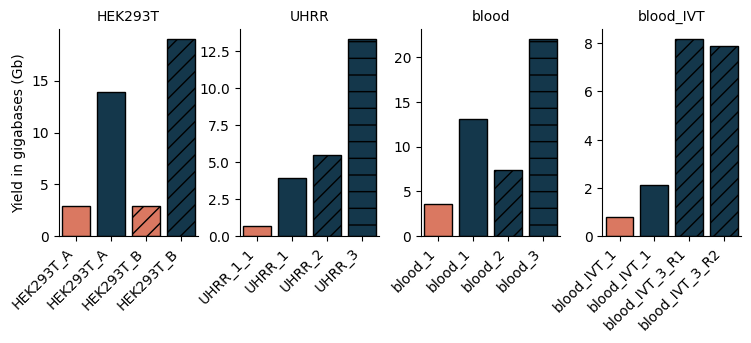

In [54]:

# Create FacetGrid
g = sns.FacetGrid(
    stats_p, col="SampleType", col_wrap=4, 
    sharex=False, sharey=False,  # Share y-axis but not x-axis
    despine=True,  # Remove grid lines and spines
    height=3, aspect=0.7  # Adjust plot size
)
custom_palette = {"RNA002": "#ee6c4d", "RNA004": "#0b3954"}

# Map barplot
g.map_dataframe(sns.barplot, x="dataset", y="Yield", hue="Chemistry", palette = custom_palette, edgecolor="black")
hatches = [['','//', '', '//'],['', '', '//', '-'], ['', '', '//', '-'],['', '', '//', '//']]

# Adjust x-axis labels
for c, ax in enumerate(g.axes.flat):
    ax.set_xticklabels([i.get_text().replace("RNA002_", "").replace("RNA004_", "") for i in ax.get_xticklabels()], rotation=45, ha="right")
    ax.grid(False)  # Remove grid
    for i, bar in enumerate(ax.patches):
        if i < 4:
            bar.set_hatch(hatches[c][i]) 


# Remove redundant y-axis labels
g.set_axis_labels("", "Yield in gigabases (Gb)")
g.set_titles("{col_name}")  # Show only the sample type as title
g.fig.subplots_adjust(wspace=0.3, hspace=0)
# Make plots closer together
plt.show()

g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_bar_plot_yield2.png",dpi=300, bbox_inches="tight")
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_bar_plot_yield2.pdf",dpi=300, bbox_inches="tight")
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_bar_plot_yield2.svg",dpi=300, bbox_inches="tight")

### Plot 2

/tmp/ipykernel_532596/1353863751.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([i.get_text().replace("RNA002_", "").replace("RNA004_", "") for i in ax.get_xticklabels()], rotation=45, ha="right")


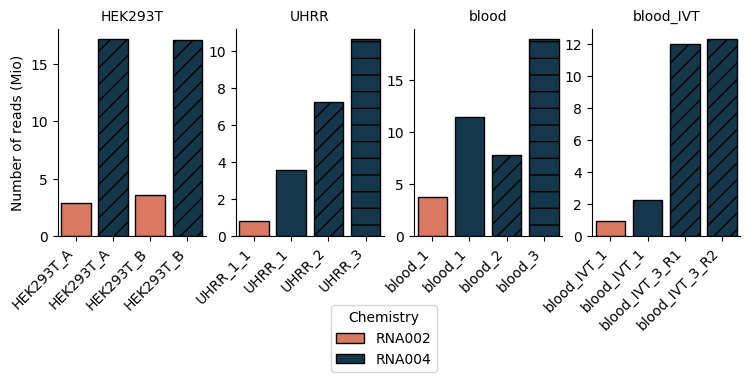

In [55]:

# Create FacetGrid
g = sns.FacetGrid(
    stats_p, col="SampleType", col_wrap=4, 
    sharex=False, sharey=False,  # Share y-axis but not x-axis
    despine=True,  # Remove grid lines and spines
    height=3, aspect=0.7  # Adjust plot size
)
custom_palette = {"RNA002": "#ee6c4d", "RNA004": "#0b3954"}

# Map barplot
g.map_dataframe(sns.barplot, x="dataset", y="Reads", hue="Chemistry", palette = custom_palette, edgecolor="black")
hatches = [['','', '//', '//'],['', '', '//', '-'], ['', '', '//', '-'],['', '', '//', '//']]

# Adjust x-axis labels
for c, ax in enumerate(g.axes.flat):
    ax.set_xticklabels([i.get_text().replace("RNA002_", "").replace("RNA004_", "") for i in ax.get_xticklabels()], rotation=45, ha="right")
    ax.grid(False)  # Remove grid
    
    for i, bar in enumerate(ax.patches):
        if i < 4:
            bar.set_hatch(hatches[c][i]) 
    if c == 3:
        ax.legend(title="Chemistry", bbox_to_anchor=(-1, -0.3), ncol=1, frameon=True)


# Remove redundant y-axis labels
g.set_axis_labels("", "Number of reads (Mio)")
g.set_titles("{col_name}")  # Show only the sample type as title
g.fig.subplots_adjust(wspace=0.2, hspace=0)
# Make plots closer together

g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_bar_plot_reads2.png",dpi=300, bbox_inches="tight")
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_bar_plot_reads2.pdf",dpi=300, bbox_inches="tight")
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_bar_plot_reads2.svg",dpi=300, bbox_inches="tight")
plt.show()


# 2) ACCURACY PLOTS

In [56]:
# RNA002 UHRR, HEK293T_A, HEK293T_B, S1_Blood, S1_Blood_IVT; RNA004 UHRR_1, UHRR_2, UHRR_3, HEK293T_A, HEK293T_B, S1_Blood, S1_Blood_IVT
nanocomp_stats1 = pl.read_csv("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/reanalysis0.7.2_NanoComp_RNA002_RNA004/NanoComp-data.tsv.gz", separator = "\t")
# RNA004 S6_Blood, S6_Blood_IVT_1, S6_Blood_IVT_2
nanocomp_stats2 = pl.read_csv("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S6_IVT_analysis/S6_0.7.2_NanoComp_RNA002_RNA004/NanoComp-data.tsv.gz", separator = "\t")
# RNA004 S5_Blood
nanocomp_stats3 = pl.read_csv("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S5_analysis_5_12_24/S5_0.7.2_NanoComp_RNA002_RNA004/NanoComp-data.tsv.gz", separator = "\t")


In [57]:
# Take 300000 reads from each dataset!
nanocomp_stats1_filt = nanocomp_stats1.group_by('dataset').head(300000)
nanocomp_stats2_filt = nanocomp_stats2.group_by('dataset').head(300000)
nanocomp_stats3_filt = nanocomp_stats3.group_by('dataset').head(300000)
nanocomp_stats = pl.concat([nanocomp_stats1_filt, nanocomp_stats2_filt, nanocomp_stats3_filt])


In [58]:
filtered = (
    nanocomp_stats
    .filter(~pl.col("dataset").str.contains("_E"))
    .filter(~pl.col("dataset").str.contains("_ribo"))
    .with_columns([pl.col("dataset")
    .str.replace("_A", "_HEK293T_A")
    .str.replace("_B", "_HEK293T_B")
    .str.replace("_basecall.0.7.2.GRCh38.bam", "")
    .str.replace("S5_analysis", "RNA004_blood_2")
    .str.replace("blood.0.7.2", "blood_1")
    .str.replace("blood_IVT.0.7.2", "blood_IVT_1")
    .str.replace("S6_IVT_LI", "blood_IVT_3_R2")
    .str.replace("S6_IVT", "blood_IVT_3_R1")
    .str.replace("S6_DRS", "blood_3")
    .str.replace(".0.7.2", "")

    ]))

In [42]:
metadata = pd.DataFrame({"sample" : filtered["dataset"].unique()})
metadata["tissue"] = metadata["sample"].str.replace("_[A|B|S|1|2|3].*$", "", regex=True)
metadata["chem_type"] = metadata["tissue"].str.replace("_.*$", "", regex=True)
metadata["ID"] = metadata["tissue"].str.replace("RNA00[2|4]_", "", regex=True)
metadata["sample_flat"] = metadata["sample"].str.replace("RNA00[2|4]_", "", regex=True)
metadata =metadata.sort_values(by = ["chem_type", "sample"])
nanocomp_stats_filt2 = filtered.join(pl.from_pandas(metadata), how = "left", left_on = "dataset", right_on = "sample")
nanocomp_pandas = nanocomp_stats_filt2.to_pandas()

In [43]:
colors_input_flowcells = {
"RNA002_HEK293T" :  "#ee6c4d",
"RNA002_blood" :"#ee6c4d", 
"RNA002_blood_IVT" :"#ee6c4d", 
"RNA002_UHRR" : "#ee6c4d", 
"RNA004_HEK293T" : "#0b3954", 
"RNA004_blood" :"#0b3954", 
"RNA004_blood_IVT" :"#0b3954", 
"RNA004_UHRR" : "#0b3954",
"Illumina" : "#8B5CF6"}
metadata['colors_flowcells'] = [colors_input_flowcells[i] for i in metadata.tissue]

In [44]:
order_fix = metadata.sort_values(by = ["chem_type", "sample_flat"])["sample"]

## Average basecall quality

### Plot 1

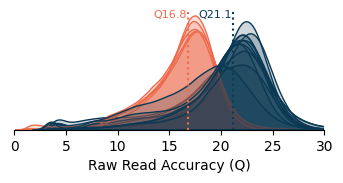

In [45]:
fig, ax = plt.subplots(figsize=(4,2.5))
sns.kdeplot(
   data=nanocomp_pandas, x="quals", hue="dataset",
   fill=True, common_norm=False, palette=metadata.set_index("sample")["colors_flowcells"].to_dict(),
   alpha=.2
)

# Compute means and add vertical lines
colors_flowcells = {"RNA002" : "#ee6c4d", "RNA004" : "#0b3954"}
means = nanocomp_pandas[nanocomp_pandas["dataset"] != "RNA004_blood_IVT"].groupby("chem_type")["quals"].median()
for chem_type, mean in means.items():
    color = colors_flowcells[chem_type]
    ax.axvline(mean, color=color, linestyle="dotted", linewidth=1.5)
    ax.text(
        mean-0.1, ax.get_ylim()[1],  # Slightly below top of plot
        f"Q{mean:.1f}", 
        color=color, ha="right", va="top", fontsize=8
    )

# Remove y-axis
ax.set_yticks([])
ax.set_ylabel('')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend([],[], frameon=False)
ax.grid(False)  # Turn off all grid lines

    
ax.set_xlim(0,30)  
# Set x-axis label
ax.set_xlabel('Raw Read Accuracy (Q)')
plt.subplots_adjust(bottom=0.4)

fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_density_quality_NEW.svg", dpi = 300, transparent=True)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_density_quality_NEW.pdf", dpi = 300, transparent=True)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_density_quality_NEW.png", dpi = 300, transparent=True)

### Plot 2

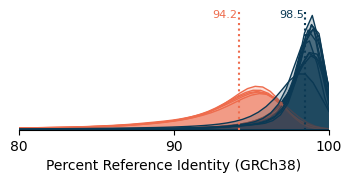

In [46]:
fig, ax = plt.subplots(figsize=(4,2.5))
sns.kdeplot(
   data=nanocomp_pandas, x="percentIdentity", hue="dataset",
   fill=True, common_norm=False, palette=metadata.set_index("sample")["colors_flowcells"].to_dict(),
   alpha=.2
)

# Compute means and add vertical lines
colors_flowcells = {"RNA002" : "#ee6c4d", "RNA004" : "#0b3954"}
means = nanocomp_pandas[nanocomp_pandas["dataset"] != "RNA004_blood_IVT"].groupby("chem_type")["percentIdentity"].median()
for chem_type, mean in means.items():
    color = colors_flowcells[chem_type]
    ax.axvline(mean, color=color, linestyle="dotted", linewidth=1.5)
    ax.text(
        mean-0.1, ax.get_ylim()[1],  # Slightly below top of plot
        f"{mean:.1f}", 
        color=color, ha="right", va="top", fontsize=8
    )
# Remove y-axis
ax.set_yticks([])
ax.set_ylabel('')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend([],[], frameon=False)
ax.grid(False)  # Turn off all grid lines

ax.set_xlim(80,100)  
# Set x-axis label
ax.set_xlabel('Percent Reference Identity (GRCh38)')
plt.xticks(range(80, 100 + 5, 10))
plt.subplots_adjust(bottom=0.4)

fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_percent_ref_identity_NEW.svg", dpi = 300, transparent=True)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_percent_ref_identity_NEW.pdf", dpi = 300, transparent=True)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_percent_ref_identity_NEW.png", dpi = 300, transparent=True)

### TABLE

In [47]:
out_table_perc_identity = nanocomp_pandas.groupby(["dataset", "sample_flat", "ID", "tissue", "chem_type"]).agg(
    avg_quals=('quals','mean'),
    median_quals=('quals','median'),
    min_quals=('quals','min'),
    max_quals=('quals','max'),
    avg_aligned_lengths=('aligned_lengths','mean'),
    median_aligned_lengths=('aligned_lengths','median'),
    min_aligned_lengths=('aligned_lengths','min'),
    max_aligned_lengths=('aligned_lengths','max'),
    avg_perc_identity=('percentIdentity','mean'),
    median_perc_identity=('percentIdentity','median'),
    min_perc_identity=('percentIdentity','min'),
    max_perc_identity=('percentIdentity','max'),
    n_reads=('readIDs','count')).reset_index()

In [49]:
out_table_perc_identity.to_csv("/home/awiercze/NEW_RNA004_PLOTS/TABLES/PAPER_NanoComp_qual_length_percID_300000reads.csv", sep = ",", index = False)

# 3) BASECALLER QUALITY COMPARISON (CHR20 ONLY)

## Load libraries

In [51]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import re
import pandas as pd 
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
import gtfparse as gtf_parse
import seaborn as sns

## Read stats from NanoComp for other basecallers

In [52]:
## Read NanoComp TSV Files for all Basecallers for HEK293T, UHRR and Blood samples 
### 1. Rodan for mafia 
rodan = "/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/Rodan_MAFIA_NanoComp/NanoComp-data.tsv.gz"
rodan_stats = pl.read_csv(rodan, separator = "\t")
rodan_stats = rodan_stats.with_columns(pl.lit("RODAN (mAFiA)").alias("basecaller"))

### 2. Diensthuber + Guppy
dienst = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/CHR20_BAMS/Diensthuber_NanoComp_3/NanoComp-data.tsv.gz"
dienst_stats = pl.read_csv(dienst, separator = "\t")
dienst_stats = dienst_stats.with_columns(pl.lit("SUP_IVT").alias("basecaller"))

### 3. Guppy FlipFlop
m6A_base = "/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/m6A_basecaller_NanoComp/NanoComp-data.tsv.gz"
m6A_base_stats = pl.read_csv(m6A_base, separator = "\t")
m6A_base_stats = m6A_base_stats.with_columns(pl.lit("m6ABasecaller").alias("basecaller"))

### 4. NEW Blood Samples RNA004 Chr20
dorado_new = "/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/BLOOD_Chr20_NanoComp/NanoComp-data.tsv.gz"
dorado_new_stats = pl.read_csv(dorado_new, separator = "\t")
dorado_new_stats = dorado_new_stats.with_columns(pl.lit("dorado").alias("basecaller"))

In [53]:
base_quals = pl.concat([dienst_stats, m6A_base_stats, dorado_new_stats])
perc_ident = pl.concat([dienst_stats.select(["dataset", "readIDs", "percentIdentity", "basecaller"]), m6A_base_stats.select(["dataset", "readIDs", "percentIdentity", "basecaller"]), rodan_stats.select(["dataset","readIDs",  "percentIdentity", "basecaller"]), dorado_new_stats.select(["dataset","readIDs",  "percentIdentity", "basecaller"])])

In [54]:
print(perc_ident.group_by("dataset").count().sort("count").head(1)) # Maximal number of reads --> 20000
perc_ident_filt = perc_ident.group_by('dataset').head(20000)
perc_ident_filt = perc_ident_filt.to_pandas()
perc_ident_filt = perc_ident_filt[~(perc_ident_filt["dataset"].str.contains("_E") | perc_ident_filt["dataset"].str.contains("_ribo"))]


/tmp/ipykernel_1487447/1634879000.py:1: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  print(perc_ident.group_by("dataset").count().sort("count").head(1)) # Maximal number of reads --> 20000


shape: (1, 2)
┌───────────────────────────────────┬───────┐
│ dataset                           ┆ count │
│ ---                               ┆ ---   │
│ str                               ┆ u32   │
╞═══════════════════════════════════╪═══════╡
│ RNA002_UHRR_basecall.0.7.2.GRCh3… ┆ 20537 │
└───────────────────────────────────┴───────┘


In [55]:
print(base_quals.group_by("dataset").count().sort("count").head(1))
base_quals_filt = base_quals.group_by('dataset').head(20000)
base_quals_filt = base_quals_filt.to_pandas()
base_quals_filt = base_quals_filt[~(base_quals_filt["dataset"].str.contains("_E") | base_quals_filt["dataset"].str.contains("_ribo"))]


/tmp/ipykernel_1487447/3863251030.py:1: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  print(base_quals.group_by("dataset").count().sort("count").head(1))


shape: (1, 2)
┌───────────────────────────────────┬───────┐
│ dataset                           ┆ count │
│ ---                               ┆ ---   │
│ str                               ┆ u32   │
╞═══════════════════════════════════╪═══════╡
│ RNA002_UHRR_basecall.0.7.2.GRCh3… ┆ 20537 │
└───────────────────────────────────┴───────┘


In [56]:
metadata = perc_ident_filt[["dataset", "basecaller"]].drop_duplicates()
metadata["basecaller_new"] = metadata.apply(lambda row: "dorado" if "0.7.2" in row["dataset"] else row["basecaller"], axis = 1)

In [ ]:
metadata["basecaller_new"] = metadata.apply(lambda row: "dorado" if "0.7.2" in row["dataset"] else row["basecaller"], axis = 1)
metadata["basecaller_new"] = metadata.apply(lambda row: "dorado_RNA002" if row["basecaller_new"] == "dorado" and "RNA002" in row["dataset"] else row["basecaller_new"], axis = 1)
metadata["basecaller_new"] = metadata.apply(lambda row: "dorado_RNA004" if row["basecaller_new"] == "dorado" and "RNA004" in row["dataset"] else row["basecaller_new"], axis = 1)
metadata["basecaller_new"] = metadata.apply(lambda row: "dienst_SUP" if "Diensthuber" in row["dataset"] else row["basecaller_new"], axis = 1)
metadata["basecaller_new"] = metadata.apply(lambda row: "dienst_SUP_IVT" if "Diensthuber_SUP_IVT" in row["dataset"] else row["basecaller_new"], axis = 1)

,dataset,basecaller,basecaller_new
20000,RNA002_A_basecall.0.7.2.GRCh38.chr20.bam,SUP_IVT,dorado_RNA002
60000,RNA004_blood_3,dorado,dorado_RNA004
80000,RNA004_UHRR_1_basecall.0.7.2.GRCh38.chr20.bam,SUP_IVT,dorado_RNA004
100000,Diensthuber_SUP_guppy_out_A.GRCh38.bam,SUP_IVT,dienst_SUP
120000,RNA004_UHRR_2_basecall.0.7.2.GRCh38.chr20.bam,SUP_IVT,dorado_RNA004
140000,RNA002_blood_GUPPY,m6ABasecaller,m6ABasecaller
180000,RNA004_blood_IVT_3_R2,dorado,dorado_RNA004
220000,RNA002_UHRR_GUPPY,m6ABasecaller,m6ABasecaller
260000,RNA002_blood_RODAN,RODAN (mAFiA),RODAN (mAFiA)
280000,Diensthuber_SUP_IVT_guppy_out_blood.GRCh38.bam,SUP_IVT,dienst_SUP_IVT


In [58]:
replace_dict_2 = {
    "Diensthuber_SUP_guppy_out_": "RNA002_",
    "Diensthuber_SUP_IVT_guppy_out_blood.GRCh38.bam" : "RNA002_blood_IVT_1",
    "_basecall.0.7.2.GRCh38.chr20.bam":"",
    "RNA002_blood_GUPPY" : "RNA002_blood_1",
    "RNA002_blood_IVT_GUPPY" : "RNA002_blood_IVT_1",
    "RNA002_blood_RODAN" : "RNA002_blood_1",
    "RNA002_blood_IVT_RODAN" : "RNA002_blood_IVT_1",
    "_GUPPY" : "",
    "RNA004_blood.0.7.2.GRCh38.chr20.bam" : "RNA004_blood_1",
    "RNA002_blood.0.7.2.GRCh38.chr20.bam" : "RNA002_blood_1",
    "RNA004_blood_IVT.0.7.2.GRCh38.chr20.bam" : "RNA004_blood_IVT_1",
    "RNA002_blood_IVT.0.7.2.GRCh38.chr20.bam" : "RNA002_blood_IVT_1",
    ".0.7.2.GRCh38.chr20.bam" : "",
    "blood.GRCh38.bam" : "blood_1",
    ".GRCh38.bam" : "",
    "_RODAN" : "",
    "RNA002_A": "RNA002_HEK293T_A",
    "RNA002_B": "RNA002_HEK293T_B",
    "RNA004_A": "RNA004_HEK293T_A",
    "RNA004_B": "RNA004_HEK293T_B"


}

metadata["sample"] = metadata["dataset"].replace(replace_dict_2, regex=True)
metadata["sample"] = metadata["sample"].replace(replace_dict_2, regex=True)

metadata["tissue"] = metadata["sample"].str.replace("_[A|B|S|1|2|3].*$", "", regex=True)
metadata["chem_type"] = metadata["tissue"].str.replace("_.*$", "", regex=True)
metadata["ID"] = metadata["tissue"].str.replace("RNA00[2|4]_", "", regex=True)
metadata["sample_flat"] = metadata["sample"].str.replace("RNA00[2|4]_", "", regex=True)

In [59]:
colors_input_flowcells = {
"RNA002_HEK293T" :  "#ee6c4d",
"RNA002_blood" :"#ee6c4d", 
"RNA002_blood_IVT" :"#ee6c4d", 
"RNA002_UHRR" : "#ee6c4d", 
"RNA004_HEK293T" : "#0b3954", 
"RNA004_blood" :"#0b3954", 
"RNA004_blood_IVT" :"#0b3954", 
"RNA004_UHRR" : "#0b3954",
"Illumina" : "#8B5CF6"}

colors_input_basecaller = {
"dorado_RNA002" :  "#EE6C4D",
"dorado_RNA004" :"#0B3954", 
"m6ABasecaller" :"#098C9A", 
"dienst_SUP" : "#8B5CF6", 
"dienst_SUP_IVT" : "#6f1d1b", 
"RODAN (mAFiA)" : "#FFBE0B"}
metadata['colors_flowcells'] = [colors_input_flowcells[i] for i in metadata.tissue]
metadata['colors_input_basecaller'] = [colors_input_basecaller[i] for i in metadata.basecaller_new]

In [60]:
base_quals_annot = pd.merge(base_quals_filt, metadata, left_on = "dataset", right_on = "dataset", how = "left")
perc_ident_annot = pd.merge(perc_ident_filt, metadata, left_on = "dataset", right_on = "dataset", how = "left")

## Plots

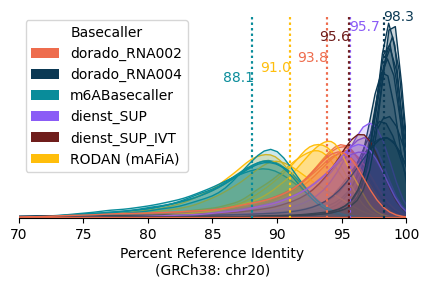

In [61]:
fig, ax = plt.subplots(figsize=(5,3))
sns.kdeplot(
   data=perc_ident_annot, x="percentIdentity", hue="dataset",
   fill=True, common_norm=False, palette=metadata.set_index("dataset")["colors_input_basecaller"].to_dict(),
   alpha=.2
)

# Compute means and add vertical lines
colors_flowcells = {"RNA002" : "#ee6c4d", "RNA004" : "#0b3954"}
means = perc_ident_annot[perc_ident_annot["dataset"] != "RNA004_blood_IVT"].groupby("basecaller_new")["percentIdentity"].median()
for chem_type, mean in means.items():
    color = colors_input_basecaller[chem_type]
    ax.axvline(mean, color=color, linestyle="dotted", linewidth=1.5)

from matplotlib.patches import Patch


# Create legend handles manually
legend_elements = [
    Patch(facecolor=color, edgecolor='none', label=bc)
    for bc, color in colors_input_basecaller.items()
]

# Add custom legend to the axis
#ax.legend(handles=legend_elements, title="Basecaller", loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=2, frameon=False)
ax.legend(handles=legend_elements, title="Basecaller")
input_scales = {
"dorado_RNA002" :  0.75,
"dorado_RNA004" : 0.95, 
"m6ABasecaller" : 0.65, 
"dienst_SUP" : 0.90, 
"dienst_SUP_IVT" :0.85, 
"RODAN (mAFiA)" : 0.70}
for chem_type, mean in means.items():
    color = colors_input_basecaller[chem_type]
    ax.axvline(mean, color=color, linestyle="dotted", linewidth=1.5)
    if chem_type == "dienst_SUP" or chem_type == "dorado_RNA004":
        ax.text(
            mean-0.1, ax.get_ylim()[1]*input_scales[chem_type],  # Slightly above top of plot
            f"{mean:.1f}", 
            color=color, ha="left", va="bottom", fontsize=10
    )
    else:
        # Adjust the position of the text for other chem_types
        ax.text(
            mean+0.1, ax.get_ylim()[1]*input_scales[chem_type],  # Slightly below top of plot
            f"{mean:.1f}", 
            color=color, ha="right", va="bottom", fontsize=10
        )
# Remove y-axis
ax.set_yticks([])
ax.set_ylabel('')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.legend([],[], frameon=False)
ax.grid(False)  # Turn off all grid lines
ax.set_xlim([70,100])
# Set x-axis label
ax.set_xlabel('Percent Reference Identity\n(GRCh38: chr20)')
plt.subplots_adjust(bottom=0.2)

fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_density_perc_identity_basecallers.svg", dpi = 300, transparent=True)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_density_perc_identity_basecallers.pdf", dpi = 300, transparent=True)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_density_perc_identity_basecallers.png", dpi = 300, transparent=True)

## Save table

In [66]:
out_table_perc_identity = perc_ident_annot.groupby(["dataset", "sample", "sample_flat", "ID", "tissue", "chem_type", "basecaller_new"]).agg(
    avg_perc_identity=('percentIdentity','mean'),
    median_perc_identity=('percentIdentity','median'),
    min_perc_identity=('percentIdentity','min'),
    max_perc_identity=('percentIdentity','max'),
    n_reads=('readIDs','count')).reset_index()

In [68]:
out_table_perc_identity.to_csv("/home/awiercze/NEW_RNA004_PLOTS/TABLES/PAPER_perc_identity_basecallers.csv", sep = ",", index = False)

# 4) POLY A TAIL LENGTH ESTIMATION

## 4.1) GLOBAL

In [4]:
import glob as glob
x  = glob.glob("/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/GLOBAL_polyA_length/*aligned.global.poly_a_tags.tsv")

In [5]:
global_polyAs = pd.DataFrame()
for i in x: 
    n_poly = pd.read_csv(i, sep = "\t", header = None, names = ["read_id", "sample", "polyA_length"])
    global_polyAs  = pd.concat([global_polyAs, n_poly], axis = 0)

In [6]:
replace_dict = {
    "_.0.7.2" : "", 
    "_A": "_HEK293T_A","_B": "_HEK293T_B",
    "_basecall.0.7.2": "",
    "S5_analysis": "RNA004_blood_2",
    "blood.0.7.2": "blood_1",
    "blood_IVT.0.7.2": "blood_IVT_1",
    "S6_IVT_LI": "blood_IVT_3_R2",
    "S6_IVT": "blood_IVT_3_R1",
    "S6_DRS": "blood_3",
    ".0.7.2": "",
    "RNA002_UHRR": "RNA002_UHRR_1",
}

In [7]:
global_polyAs["sample"] = global_polyAs["sample"].replace(replace_dict, regex = True)
global_polyAs["tissue"] = global_polyAs["sample"].str.replace("_[A|B|S|1|2|3].*$", "", regex=True)
global_polyAs["chem_type"] = global_polyAs["tissue"].str.replace("_.*$", "", regex=True)
global_polyAs["ID"] = global_polyAs["tissue"].str.replace("RNA00[2|4]_", "", regex=True)
global_polyAs["sample_flat"] = global_polyAs["sample"].str.replace("RNA00[2|4]_", "", regex=True)

In [47]:
color_dict_global_polyA = {'RNA004_blood_IVT_3_R2': '#ee6c4d',
    'RNA004_HEK293T_B': '#0b3954',
    'RNA004_blood_1': '#098c9a',
    'RNA002_blood_1': '#f3d427',
    'RNA004_blood_3': '#098c9a',
    'RNA004_blood_IVT_3_R1': '#ee6c4d',
    'RNA004_UHRR_2': '#8b5cf6',
    'RNA004_UHRR_3': '#8b5cf6',
    'RNA004_HEK293T_A': '#0b3954',
    'RNA004_UHRR_1': '#8b5cf6',
    'RNA002_UHRR_1': '#f3d427',
    'RNA002_UHRR': '#f3d427',

    'RNA002_HEK293T_B': '#4c8db3',
    'RNA004_blood_2': '#098c9a',
    'RNA002_blood_IVT_1': "#f3d427",
    'RNA004_blood_IVT_1': '#ee6c4d',
    'RNA002_HEK293T_A': '#4c8db3'}

color_dict_global_polyA = {
  "RNA002_HEK293T_A" :  "#45a80b",
  "RNA002_HEK293T_B" :  "#9ac582",

  "RNA002_blood_1" :"#45a80b",
  "RNA002_blood_IVT_1" :"#45a80b",
  "RNA002_UHRR_1" : "#45a80b",
  "RNA002_UHRR" : "#45a80b",

  "RNA004_HEK293T_A" : "#EE6C4D",
  "RNA004_HEK293T_B" : "#E69581",

  "RNA004_blood_1" :"#0B3954",
  "RNA004_blood_IVT_1" :"#8b5cf6",
  "RNA004_UHRR_1" : "#098C9A",
  "RNA004_UHRR_2" : "#26AFBE",
  "RNA004_UHRR_3" : "#93C6CC", 
  "RNA004_blood_2" : "#177BB5",
  "RNA004_blood_3" : "#38A6E5",
  "RNA004_blood_IVT_3" : "#BA9EFA",
  "RNA004_blood_IVT_3_R2" : "#E3D8FD"
}

In [42]:
global_polyAs.groupby("sample").polyA_length.mean()

sample
RNA002_HEK293T_A       84.646739
RNA002_HEK293T_B       82.804492
RNA002_UHRR_1          75.855668
RNA002_blood_1         83.239133
RNA002_blood_IVT_1    130.389996
RNA004_HEK293T_A       92.159991
RNA004_HEK293T_B       95.376746
RNA004_UHRR_1          85.360344
RNA004_UHRR_2          86.314162
RNA004_UHRR_3          94.249395
RNA004_blood_1         95.081099
RNA004_blood_IVT_1    142.378104
Name: polyA_length, dtype: float64

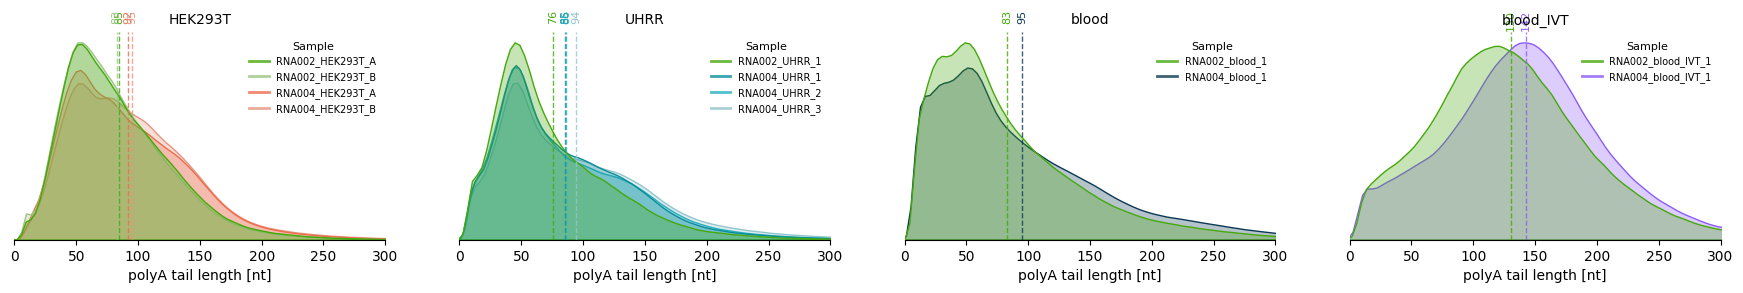

In [48]:
import numpy as np
from matplotlib.lines import Line2D

# Create FacetGrid
global_polyAs = global_polyAs.sort_values(by = ["ID", "sample"])
sample_order = list(global_polyAs["sample"].unique()) 

g = sns.FacetGrid(
    global_polyAs, col="ID", col_wrap=5, 
    sharex=True, sharey=False,  # Share y-axis but not x-axis
    despine=True,  # Remove grid lines and spines
    height=3, aspect=1.5  # Adjust plot size
)

# Map barplot
g.map_dataframe(sns.kdeplot, x="polyA_length", hue="sample",
   fill=True, common_norm=False, palette=color_dict_global_polyA,
   alpha=.3
)


for ax, (gene_id, group_df) in zip(g.axes.flat, global_polyAs.groupby("ID")):
    present_samples = group_df["sample"].unique()
    for sample in present_samples:
        df_sample = group_df[group_df["sample"] == sample]
        mean_tail = df_sample["polyA_length"].mean()
        color = color_dict_global_polyA[sample]
        ax.axvline(mean_tail, linestyle="--", color=color, alpha=0.8, linewidth=1)
        if np.isnan(mean_tail):
            continue
        ax.text(
            mean_tail,                # x position
            ax.get_ylim()[1] * 1.11, # y position near the top
            round(mean_tail),      # text
            color=color,
            rotation = 90,
            fontsize=8,
            ha='center',
            va='top'
        )
    
    legend_elements = [
        Line2D([0], [0], color=color_dict_global_polyA[s], lw=2, label=s, alpha=0.8)
        for s in present_samples
    ]
    ax.legend(handles=legend_elements, title='Sample', fontsize=7, title_fontsize=8,
              loc='upper right', bbox_to_anchor=(1, 1), frameon=False)

# Adjust x-axis labels
for c, ax in enumerate(g.axes.flat):
    ax.grid(False)  # Remove grid
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlim([0,300])



# Remove redundant y-axis labels
g.set_axis_labels('polyA tail length [nt]', "")
g.set_titles("{col_name}")  # Show only the sample type as title
g.fig.subplots_adjust(wspace=0.2, hspace=0)
# Make plots closer together
plt.show()

g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_GLOBAL2.svg", dpi = 300)
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_GLOBAL2.pdf", dpi = 300)
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_GLOBAL2.png", dpi = 300)

## 4.2) GENE SPECIFIC

In [13]:
import glob
import pysam
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from collections import defaultdict
import gzip
import pysam
import os
import seaborn as sns
from matplotlib.patches import Patch
import re

In [14]:
# ========= PARSE GTF =========
def parse_gtf(gtf_path):
    genes = []
    opener = gzip.open if gtf_path.endswith(".gz") else open
    with opener(gtf_path, "rt") as f:
        for line in f:
            if line.startswith("#") or "\tgene\t" not in line:
                continue
            parts = line.strip().split("\t")
            chrom, source, feature, start, end, score, strand, frame, attributes = parts
            gene_id = None
            gene_name = None
            gene_type = None
            for attr in attributes.split(";"):
                if "gene_id" in attr:
                    gene_id = attr.split('"')[1]
                if "gene_name" in attr:
                    gene_name = attr.split('"')[1]
                if "gene_type" in attr:
                    gene_type = attr.split('"')[1]
                if gene_id and gene_name and gene_type:
                    break
            if gene_id:
                genes.append({
                    "gene_id": gene_id,
                    "chrom": chrom,
                    "start": int(start),
                    "end": int(end),
                    "strand": strand,
                    "gene_name" : gene_name,
                    "gene_type" : gene_type
                })
    return genes

In [3]:

# ========= CONFIGURATION =========
GTF_PATH = "/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/BEDMETHYL_files/last_filter_round/test/gencode.v43.sorted.gtf"  # Can be gzipped (.gtf.gz)
STRANDED = False  # Set to True if your reads are strand-specific
NUM_PROCESSES = 100

In [4]:
print("Parsing GTF...")
gene_list = parse_gtf(GTF_PATH)

Parsing GTF...


In [5]:
bam_files = [
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_UHRR_2_basecall.0.7.2.GRCh38.bam',
    #'/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_UHRR_1_basecall.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_blood_IVT.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA002_B_basecall.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA002_blood_IVT.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_blood.0.7.2.GRCh38.bam',
    #'/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA002_UHRR_basecall.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA002_blood.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_UHRR_3.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_A_basecall.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA002_A_basecall.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/DORADO_0_7_2_folder/RNA004_B_basecall.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S6_IVT_analysis/RNA004_S6_DRS_basecall.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S6_IVT_analysis/RNA004_S6_IVT_LI_basecall.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S6_IVT_analysis/RNA004_S6_IVT_basecall.0.7.2.GRCh38.bam',
    '/raid/chhewel_analysis/RNA004_Manuscript_reanalysis/S5_analysis_5_12_24/RNA004_S5_DRS_basecall.0.7.2.GRCh38.bam'
    ]

In [ ]:
# ========= PROCESS ONE GENE =========
def process_gene(gene):
    BAM = pysam.AlignmentFile(BAM_PATH, "rb")
    reads = BAM.fetch(gene["chrom"], gene["start"], gene["end"])
    lengths = []
    for read in reads:
        if read.is_unmapped or not read.has_tag("pt"):
            continue
        if STRANDED:
            read_strand = "-" if read.is_reverse else "+"
            if read_strand != gene["strand"]:
                continue
        try:
            pt = read.get_tag("pt")
            lengths.append(pt)
        except KeyError:
            continue
    BAM.close()
    if lengths:
        return {
            "gene_id": gene["gene_id"],
            "gene_name": gene["gene_name"],
            "gene_type": gene["gene_type"],
            "chr" : gene["chrom"],
            "start" : gene["start"], 
            "end" : gene["end"],
            "mean_tail": float(np.mean(lengths)),
            "median_tail": float(np.median(lengths)),
            "min_tail": float(np.min(lengths)),
            "max_tail": float(np.max(lengths)),
            "count": len(lengths)
        }
    else:
        return None


In [ ]:
for BAM_PATH in bam_files:
    sample_name = os.path.basename(BAM_PATH).replace(".0.7.2.GRCh38.bam", "").replace("_basecall", "").replace("_A", "_HEK293T_A").replace("_B", "_HEK293T_B")

    print(f"Processing {len(gene_list)} genes using {NUM_PROCESSES} cores for {sample_name}...")
    with Pool(processes=NUM_PROCESSES) as pool:
        results = pool.map(process_gene, gene_list)

    # Filter out None results
    results = [r for r in results if r is not None]

    # Save to CSV
    df = pd.DataFrame(results)
    df.to_csv("/home/awiercze/" + sample_name + "polyA_tail_lengths_per_gene.csv", index=False)
    print("Done! Results saved to /home/awiercze/" + sample_name + "polyA_tail_lengths_per_gene.csv")


### EXTRACT POLY A TAIL LENGTH PER GENE

In [29]:
# Extract output files
polyA_tails = glob.glob("RNA00*polyA_tail_lengths_per_gene.csv")

In [30]:
polyA_tails


['RNA004_S6_IVT_LI.polyA_tail_lengths_per_gene.csv',
 'RNA004_B.polyA_tail_lengths_per_gene.csv',
 'RNA004_blood.polyA_tail_lengths_per_gene.csv',
 'RNA002_A.0.7.2.GRCh38.v46.sorted.bam.polyA_tail_lengths_per_gene.csv',
 'RNA002_blood.polyA_tail_lengths_per_gene.csv',
 'RNA004_S6_DRS.polyA_tail_lengths_per_gene.csv',
 'RNA004_S6_IVT.polyA_tail_lengths_per_gene.csv',
 'RNA004_UHRR_2.polyA_tail_lengths_per_gene.csv',
 'RNA004_UHRR_3.polyA_tail_lengths_per_gene.csv',
 'RNA004_A.polyA_tail_lengths_per_gene.csv',
 'RNA004_UHRR_1.polyA_tail_lengths_per_gene.csv',
 'RNA002_UHRR.polyA_tail_lengths_per_gene.csv',
 'RNA002_B.polyA_tail_lengths_per_gene.csv',
 'RNA004_S5_DRS.polyA_tail_lengths_per_gene.csv',
 'RNA004_A.0.7.2.GRCh38.v46.sorted.bam.polyA_tail_lengths_per_gene.csv',
 'RNA002_blood_IVT.polyA_tail_lengths_per_gene.csv',
 'RNA004_blood_IVT.polyA_tail_lengths_per_gene.csv',
 'RNA002_A.polyA_tail_lengths_per_gene.csv']

In [31]:
polyA_tails = [x for x in polyA_tails if not ".GRCh38.v46.sorted.bam.polyA_tail_lengths_per_gene.csv" in x]

In [32]:
all_tails_stack = pd.DataFrame()
for i in polyA_tails:
    sample_name=i.replace(".polyA_tail_lengths_per_gene.csv", "").replace("_A", "_HEK293T_A").replace("_B", "_HEK293T_B").replace("_basecall.0.7.2.GRCh38.bam", "").replace("S5_analysis", "RNA004_blood_2").replace("blood.0.7.2", "blood_1").replace("blood_IVT.0.7.2", "blood_IVT_1").replace("S6_IVT_LI", "blood_IVT_3_R2").replace("S6_IVT", "blood_IVT_3_R1").replace("S6_DRS", "blood_3").replace(".0.7.2", "").replace("S5_DRS", "blood_2")
    sample_name = re.sub("blood$", "blood_1", sample_name)
    sample_name = re.sub("blood_IVT$", "blood_IVT_1", sample_name)

    print(sample_name)

    df = pd.read_csv(i)
    #df = df.rename(columns = {"mean_tail": "mean_tail-" + sample_name, "median_tail": "median_tail-" + sample_name, "min_tail" : "min_tail-" + sample_name, "max_tail" : "max_tail-"+ sample_name, "count" : "count-" + sample_name})
    df["sample"] = sample_name
    all_tails_stack = pd.concat([all_tails_stack, df], axis = 0)
   
    

RNA004_blood_IVT_3_R2
RNA004_HEK293T_B
RNA004_blood_1
RNA002_blood_1
RNA004_blood_3
RNA004_blood_IVT_3_R1
RNA004_UHRR_2
RNA004_UHRR_3
RNA004_HEK293T_A
RNA004_UHRR_1
RNA002_UHRR
RNA002_HEK293T_B
RNA004_blood_2
RNA002_blood_IVT_1
RNA004_blood_IVT_1
RNA002_HEK293T_A


In [21]:
polyA_tails

[]

In [33]:
all_tails_stack_cov10 = all_tails_stack[all_tails_stack["count"] >= 10]
all_tails_stack_cov10_protein = all_tails_stack_cov10[all_tails_stack_cov10["gene_type"] == "protein_coding"]

### Plot 1

In [34]:
metadata = pd.DataFrame({"sample" : all_tails_stack_cov10["sample"].unique()})
metadata["tissue"] = metadata["sample"].str.replace("_[A|B|S|1|2|3].*$", "", regex=True)
metadata["chem_type"] = metadata["tissue"].str.replace("_.*$", "", regex=True)
metadata["ID"] = metadata["tissue"].str.replace("RNA00[2|4]_", "", regex=True)
metadata["sample_flat"] = metadata["sample"].str.replace("RNA00[2|4]_", "", regex=True)

In [35]:
colors_input = {
"RNA002_HEK293T" :  "#E69581",
"RNA002_blood" :"#51788F", 
"RNA002_blood_IVT" :"#BA9EFA", 
"RNA002_UHRR" : "#4FA6AF", 
"RNA004_HEK293T" : "#EE6C4D", 
"RNA004_blood" :"#0B3954", 
"RNA004_blood_IVT" :"#8b5cf6", 
"RNA004_UHRR" : "#098C9A"}

color_dict_global_polyA = {
  "RNA002_HEK293T_A" :  "#EE6C4D",
  "RNA002_HEK293T_B" :  "#E69581",

  "RNA002_blood_1" :"#0B3954",
  "RNA002_blood_IVT_1" :"#8b5cf6",
  "RNA002_UHRR_1" : "#098C9A",
  "RNA002_UHRR" : "#098C9A",

  "RNA004_HEK293T_A" : "#EE6C4D",
  "RNA004_HEK293T_B" : "#E69581",

  "RNA004_blood_1" :"#0B3954",
  "RNA004_blood_IVT_1" :"#8b5cf6",
  "RNA004_UHRR_1" : "#098C9A",
  "RNA004_UHRR_2" : "#26AFBE",
  "RNA004_UHRR_3" : "#93C6CC", 
  "RNA004_blood_2" : "#177BB5",
  "RNA004_blood_3" : "#38A6E5",
  "RNA004_blood_IVT_3" : "#BA9EFA",
  "RNA004_blood_IVT_3_R2" : "#E3D8FD"
}
metadata['colors'] = [colors_input[i] for i in metadata.tissue]

colors_input_tissue = {
"HEK293T" :  "#EE6C4D",
"blood" :"#0b3954", 
"blood_IVT" :"#8b5cf6", 
"UHRR" : "#098C9A"}
metadata['colors_tissue'] = [colors_input_tissue[i] for i in metadata.ID]

colors_input_flowcells = {
"RNA004" :  "#0b3954",
"RNA002" :"#ee6c4d"}
metadata['colors_flowcells'] = [colors_input_flowcells[i] for i in metadata.chem_type]

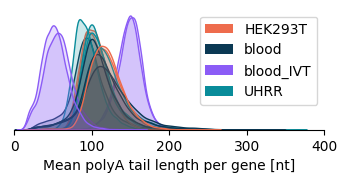

In [36]:
fig, ax = plt.subplots(figsize=(4,2.5))
sns.kdeplot(
   data=all_tails_stack_cov10_protein, x="mean_tail", hue="sample",
   fill=True, common_norm=False, palette=metadata.set_index("sample")["colors_tissue"].to_dict(),
   alpha=.2
)
legend_elements = [
    Patch(facecolor=color, edgecolor='none', label=bc)
    for bc, color in colors_input_tissue.items()
]
# Remove y-axis
ax.set_yticks([])
ax.set_ylabel('')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(handles=legend_elements, frameon="True" , bbox_to_anchor=(1, 1))
ax.grid(False)  # Turn off all grid lines

    
ax.set_xlim(0,400)  
# Set x-axis label
ax.set_xlabel('Mean polyA tail length per gene [nt]')
plt.subplots_adjust(bottom=0.4)

fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_all_NEW_protein.svg", dpi = 300, transparent=True)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_all_NEW_protein.pdf", dpi = 300, transparent=True)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_all_NEW_protein.png", dpi = 300, transparent=True)

### Supplementary Plot: PER GENE TYPE POLY A TAIL LENGTH

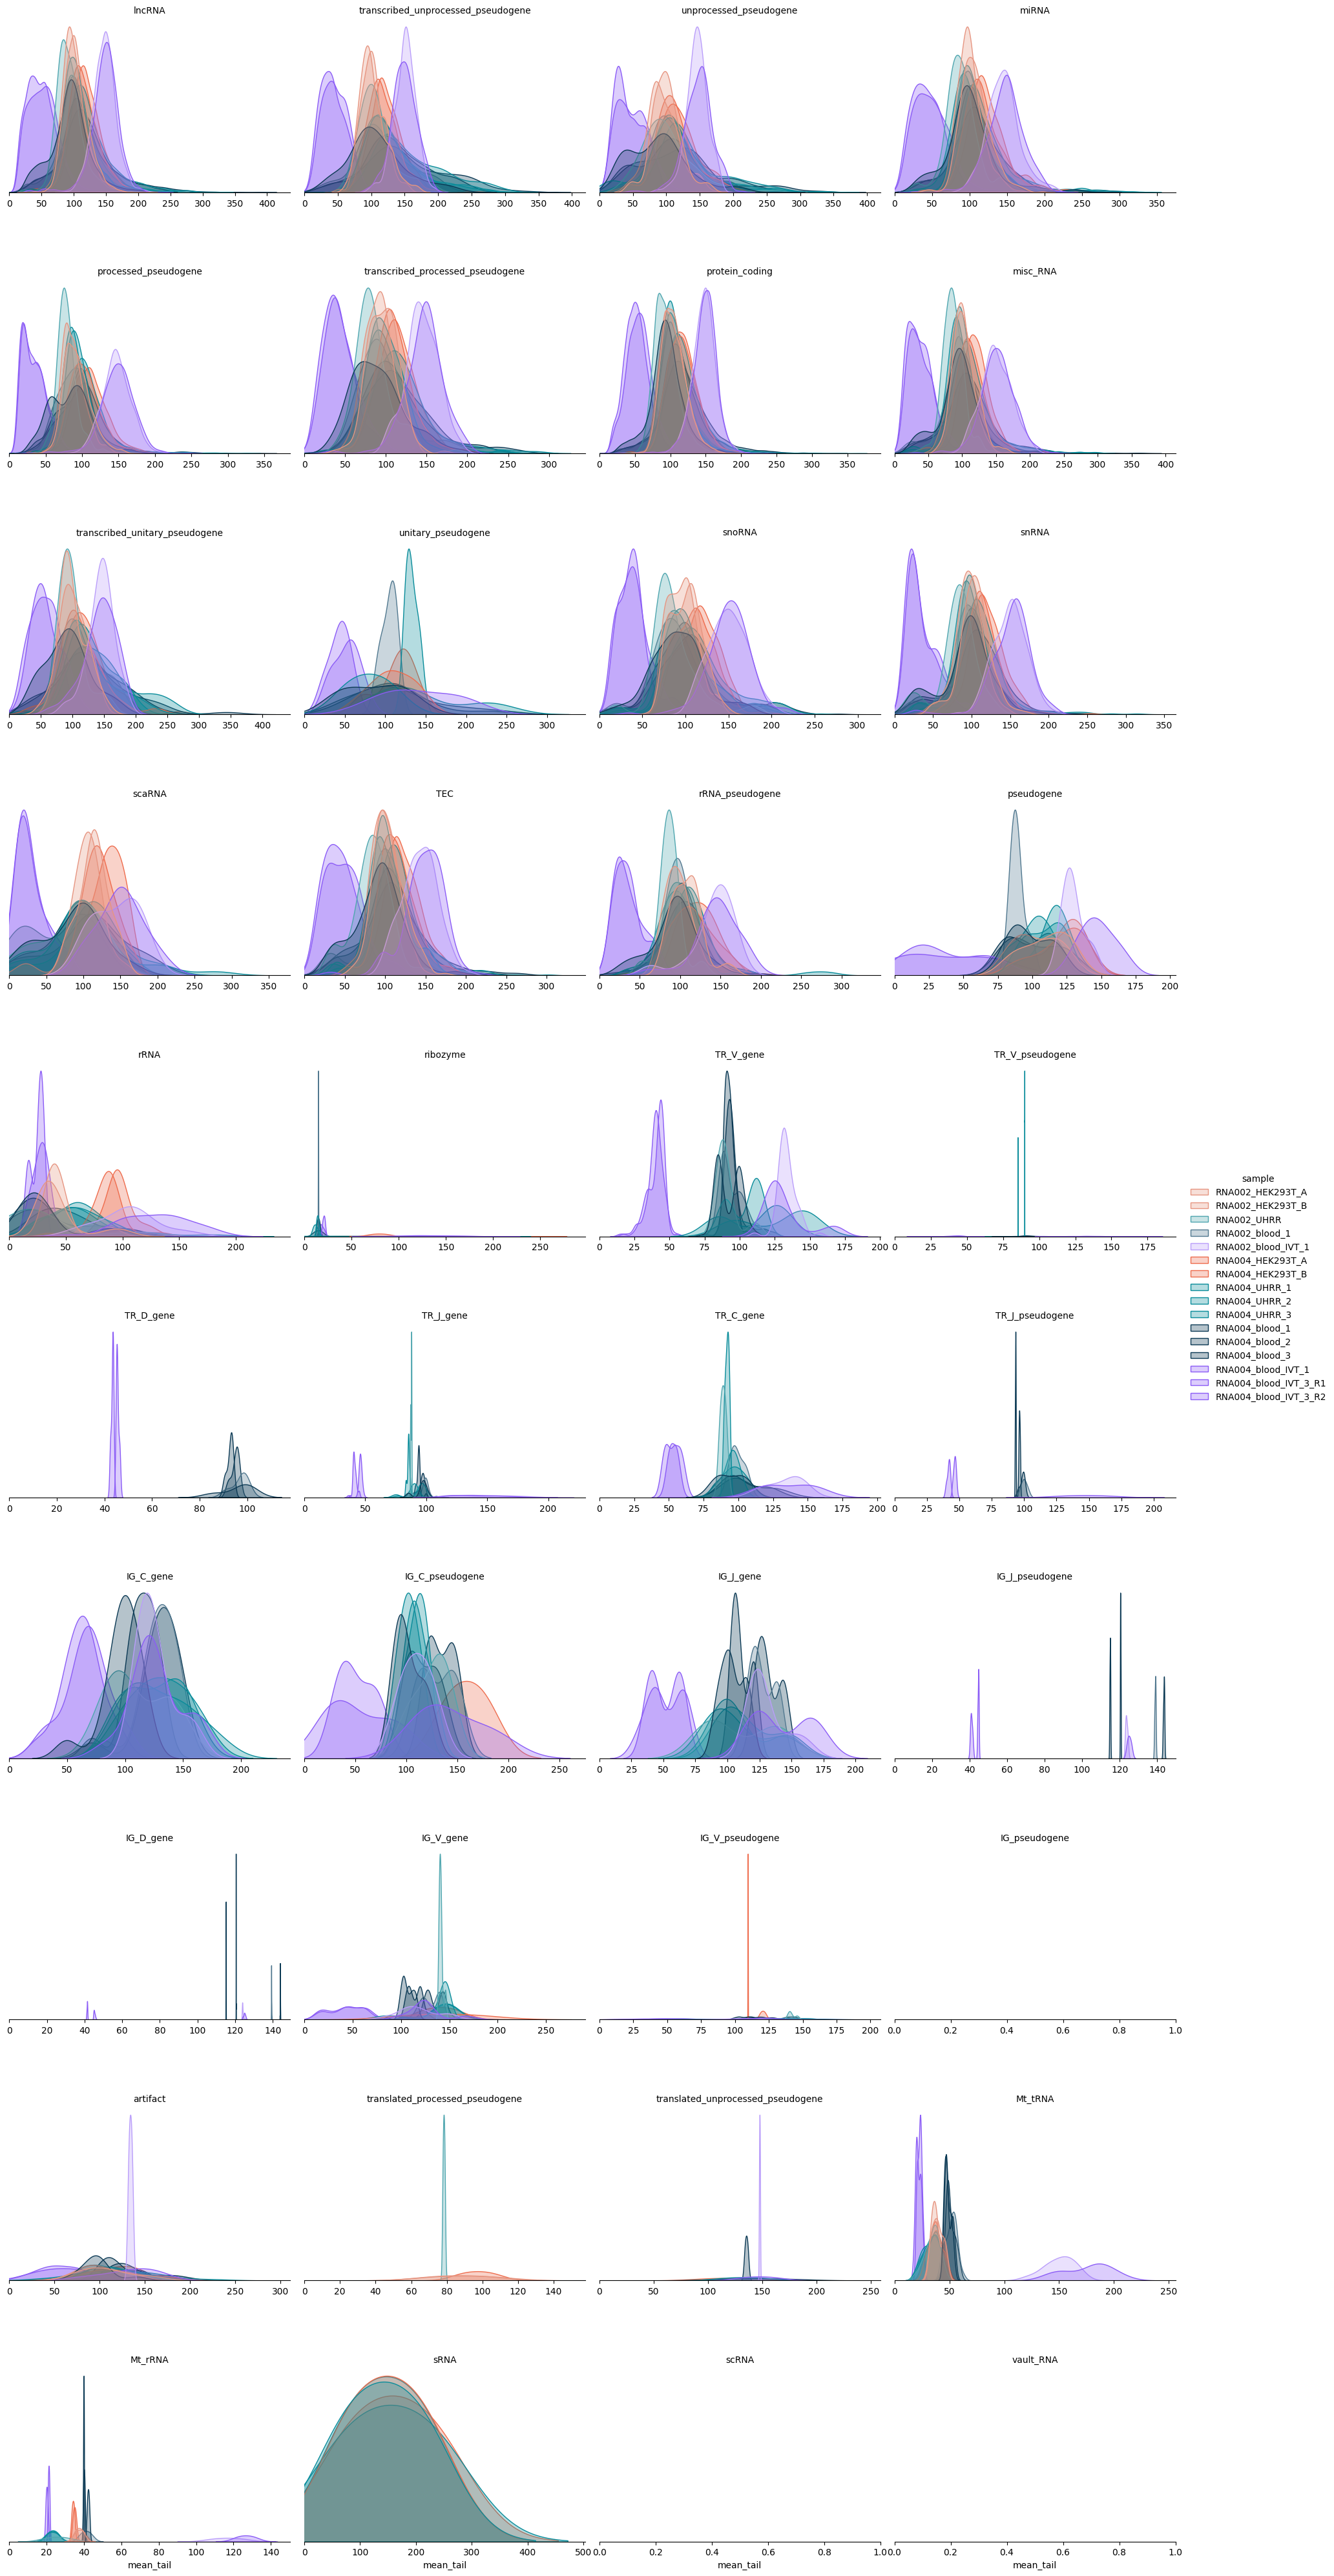

In [ ]:
g = sns.FacetGrid(
    all_tails_stack_cov10, col="gene_type", col_wrap=4, hue = "sample", palette=metadata.set_index("sample")["colors"].to_dict(),
    sharex=False, sharey=False,  # Share y-axis but not x-axis
    despine=True,  # Remove grid lines and spines
    height=4, aspect=1.2  # Adjust plot size
)
custom_palette = {"RNA002": "#ee6c4d", "RNA004": "#0b3954"}

# Map barplot
g.map_dataframe(sns.kdeplot,x="mean_tail", fill=True, common_norm=False, alpha=.3, warn_singular=False)
# Adjust x-axis labels
for c, ax in enumerate(g.axes.flat):
    ax.grid(False)  # Remove grid
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlim([0,None])
g.set_titles("{col_name}") 

g.add_legend(label_order = sorted(all_tails_stack_cov10["sample"].drop_duplicates().to_list()))


g.fig.subplots_adjust(wspace=0.05, hspace=0.5)
# Make plots closer together

g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_all_split_per_gene_type.pdf", dpi = 300)
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_all_split_per_gene_type.png", dpi = 300)
plt.show()


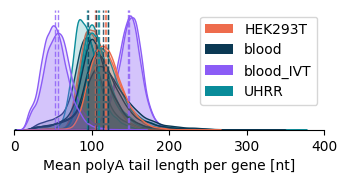

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(4, 2.5))

# Plot KDEs
sns.kdeplot(
   data=all_tails_stack_cov10_protein, x="mean_tail", hue="sample",
   fill=True, common_norm=False, 
   palette=metadata.set_index("sample")["colors_tissue"].to_dict(),
   alpha=.2,
   ax=ax
)

# Add dashed vertical lines at each sample's mean tail length
for sample_name, group in all_tails_stack_cov10_protein.groupby("sample"):
    mean_val = group["mean_tail"].mean()
    color = metadata.set_index("sample").loc[sample_name, "colors_tissue"]
    ax.axvline(mean_val, linestyle="--", color=color, alpha=0.8, linewidth=1)

# Legend from input tissue color map
legend_elements = [
    Patch(facecolor=color, edgecolor='none', label=bc)
    for bc, color in colors_input_tissue.items()
]
ax.legend(handles=legend_elements, frameon=True, bbox_to_anchor=(1, 1))

# Style tweaks
ax.set_yticks([])
ax.set_ylabel('')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.set_xlim(0, 400)
ax.set_xlabel('Mean polyA tail length per gene [nt]')
plt.subplots_adjust(bottom=0.4)


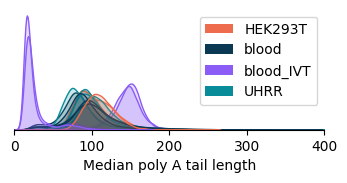

In [39]:
fig, ax = plt.subplots(figsize=(4,2.5))
sns.kdeplot(
   data=all_tails_stack_cov10_protein, x="median_tail", hue="sample",
   fill=True, common_norm=False, palette=metadata.set_index("sample")["colors_tissue"].to_dict(),
   alpha=.2
)
legend_elements = [
    Patch(facecolor=color, edgecolor='none', label=bc)
    for bc, color in colors_input_tissue.items()
]
# Remove y-axis
ax.set_yticks([])
ax.set_ylabel('')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(handles=legend_elements, frameon="True" , bbox_to_anchor=(1, 1))
ax.grid(False)  # Turn off all grid lines

    
ax.set_xlim(0,400)  
# Set x-axis label
ax.set_xlabel('Median poly A tail length')
plt.subplots_adjust(bottom=0.4)

fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_all_NEW_protein_median.svg", dpi = 300, transparent=True)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_all_NEW_protein_median.pdf", dpi = 300, transparent=True)
fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_all_NEW_protein_median.png", dpi = 300, transparent=True)

### Plot 2

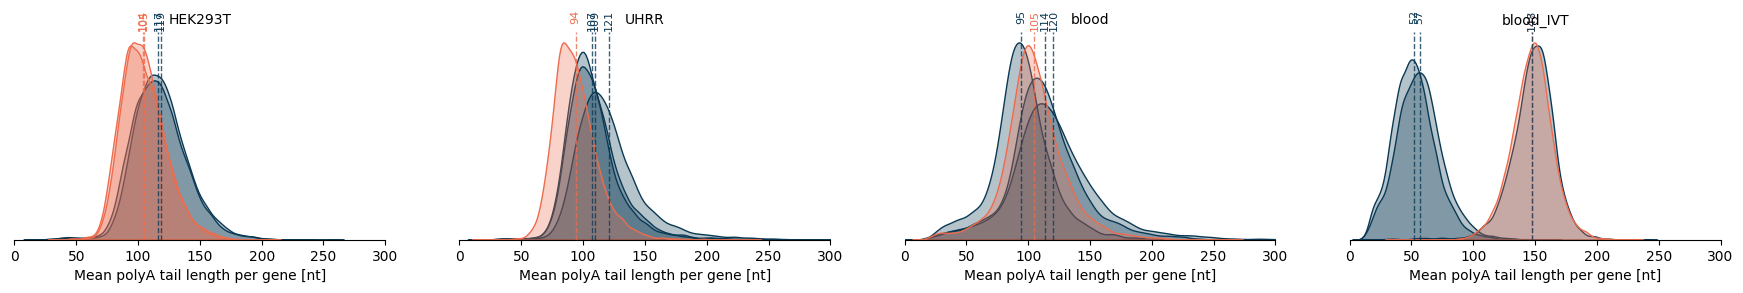

In [40]:
# Create FacetGrid
import numpy as np
all_tails_stack_annot = pd.merge(all_tails_stack_cov10_protein, metadata, on = "sample", how = "left")
all_tails_stack_annot = all_tails_stack_annot.sort_values(by = ["ID", "sample"])
sample_order = list(all_tails_stack_annot["sample"].unique()) 
g = sns.FacetGrid(
    all_tails_stack_annot, col="ID", col_wrap=5, 
    sharex=True, sharey=False,  # Share y-axis but not x-axis
    despine=True,  # Remove grid lines and spines
    height=3, aspect=1.5  # Adjust plot size
)

# Map barplot
g.map_dataframe(sns.kdeplot, x="mean_tail", hue="sample",
   fill=True, common_norm=False, palette=metadata.set_index("sample")["colors_flowcells"].to_dict(),
   alpha=.3
)

for ax, (gene_id, group_df) in zip(g.axes.flat, all_tails_stack_annot.groupby("ID")):
    for sample in sample_order:
        df_sample = group_df[group_df["sample"] == sample]
        mean_tail = df_sample["mean_tail"].mean()
        color = metadata.set_index("sample").loc[sample, "colors_flowcells"]
        ax.axvline(mean_tail, linestyle="--", color=color, alpha=0.8, linewidth=1)
        if np.isnan(mean_tail):
            continue
        ax.text(
            mean_tail,                # x position
            ax.get_ylim()[1] * 1.11, # y position near the top
            round(mean_tail),      # text
            color=color,
            rotation = 90,
            fontsize=8,
            ha='center',
            va='top'
        )

# Adjust x-axis labels
for c, ax in enumerate(g.axes.flat):
    ax.grid(False)  # Remove grid
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlim([0,300])



# Remove redundant y-axis labels
g.set_axis_labels('Mean polyA tail length per gene [nt]', "")
g.set_titles("{col_name}")  # Show only the sample type as title
g.fig.subplots_adjust(wspace=0.2, hspace=0)
# Make plots closer together
plt.show()

g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_all_split_NEW_protein.svg", dpi = 300)
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_all_split_NEW_protein.pdf", dpi = 300)
g.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_all_split_NEW_protein.png", dpi = 300)

### Create correlation plots 

#### Join Table horizontally

In [212]:
all_tails = pd.DataFrame()
for i in polyA_tails:
    sample_name=i.replace(".polyA_tail_lengths_per_gene.csv", "").replace("_A", "_HEK293T_A").replace("_B", "_HEK293T_B").replace("_basecall.0.7.2.GRCh38.bam", "").replace("S5_analysis", "RNA004_blood_2").replace("blood.0.7.2", "blood_1").replace("blood_IVT.0.7.2", "blood_IVT_1").replace("S6_IVT_LI", "blood_IVT_3_R2").replace("S6_IVT", "blood_IVT_3_R1").replace("S6_DRS", "blood_3").replace(".0.7.2", "").replace("S5_DRS", "blood_2")
    print(sample_name)
    df = pd.read_csv(i)
    df = df.rename(columns = {"mean_tail": "mean_tail-" + sample_name, "median_tail": "median_tail-" + sample_name, "min_tail" : "min_tail-" + sample_name, "max_tail" : "max_tail-"+ sample_name, "count" : "count-" + sample_name})
    if (len(all_tails) == 0):
        all_tails = df
    else:
        all_tails = pd.merge(
            left=all_tails, 
            right=df,
            how='left',
            on=df.columns[0:6].to_list()
        )
    

RNA004_blood_IVT_3_R2
RNA004_HEK293T_B
RNA004_blood
RNA002_blood
RNA004_blood_3
RNA004_blood_IVT_3_R1
RNA004_UHRR_2
RNA004_UHRR_3
RNA004_HEK293T_A
RNA004_UHRR_1
RNA002_UHRR
RNA002_HEK293T_B
RNA004_blood_2
RNA002_blood_IVT
RNA004_blood_IVT
RNA002_HEK293T_A


In [213]:
comp_list = [['RNA004_UHRR_1', 'RNA002_UHRR'],
['RNA004_UHRR_2', 'RNA002_UHRR'],
['RNA004_UHRR_3', 'RNA002_UHRR'],
['RNA004_UHRR_1', 'RNA004_UHRR_2'],
['RNA004_UHRR_1', 'RNA004_UHRR_3'],
['RNA004_UHRR_2', 'RNA004_UHRR_3'],
['RNA004_HEK293T_B', 'RNA002_HEK293T_B'],
['RNA004_HEK293T_A', 'RNA002_HEK293T_A'],
['RNA004_HEK293T_A', 'RNA004_HEK293T_B'],
['RNA002_HEK293T_A', 'RNA002_HEK293T_B'],
['RNA004_blood', 'RNA002_blood'],
['RNA004_blood_2', 'RNA002_blood'],
['RNA004_blood_3', 'RNA002_blood'],
['RNA004_blood_2', 'RNA004_blood_3'], 
['RNA004_blood', 'RNA004_blood_3'], 
['RNA004_blood', 'RNA004_blood_2']]

comp_list

[['RNA004_UHRR_1', 'RNA002_UHRR'],
 ['RNA004_UHRR_2', 'RNA002_UHRR'],
 ['RNA004_UHRR_3', 'RNA002_UHRR'],
 ['RNA004_UHRR_1', 'RNA004_UHRR_2'],
 ['RNA004_UHRR_1', 'RNA004_UHRR_3'],
 ['RNA004_UHRR_2', 'RNA004_UHRR_3'],
 ['RNA004_HEK293T_B', 'RNA002_HEK293T_B'],
 ['RNA004_HEK293T_A', 'RNA002_HEK293T_A'],
 ['RNA004_HEK293T_A', 'RNA004_HEK293T_B'],
 ['RNA002_HEK293T_A', 'RNA002_HEK293T_B'],
 ['RNA004_blood', 'RNA002_blood'],
 ['RNA004_blood_2', 'RNA002_blood'],
 ['RNA004_blood_3', 'RNA002_blood'],
 ['RNA004_blood_2', 'RNA004_blood_3'],
 ['RNA004_blood', 'RNA004_blood_3'],
 ['RNA004_blood', 'RNA004_blood_2']]

In [214]:
for i in comp_list:
    plots = []
    col_counts = ["count-" + k for k in i]
    col_means = ["mean_tail-" +  k for k in i]
    input_col = col_counts + col_means
    print(input_col)
    new_df = all_tails[input_col].dropna()
    
    new_df_cov10 = new_df[(new_df[col_counts[0]] >= 10) & (new_df[col_counts[1]] >= 10)]
    print(len(new_df))
    print(len(new_df_cov10))

['count-RNA004_UHRR_1', 'count-RNA002_UHRR', 'mean_tail-RNA004_UHRR_1', 'mean_tail-RNA002_UHRR']
25176
13430
['count-RNA004_UHRR_2', 'count-RNA002_UHRR', 'mean_tail-RNA004_UHRR_2', 'mean_tail-RNA002_UHRR']
25414
13517
['count-RNA004_UHRR_3', 'count-RNA002_UHRR', 'mean_tail-RNA004_UHRR_3', 'mean_tail-RNA002_UHRR']
25680
13522
['count-RNA004_UHRR_1', 'count-RNA004_UHRR_2', 'mean_tail-RNA004_UHRR_1', 'mean_tail-RNA004_UHRR_2']
30022
20996
['count-RNA004_UHRR_1', 'count-RNA004_UHRR_3', 'mean_tail-RNA004_UHRR_1', 'mean_tail-RNA004_UHRR_3']
31110
22011
['count-RNA004_UHRR_2', 'count-RNA004_UHRR_3', 'mean_tail-RNA004_UHRR_2', 'mean_tail-RNA004_UHRR_3']
31563
23079
['count-RNA004_HEK293T_B', 'count-RNA002_HEK293T_B', 'mean_tail-RNA004_HEK293T_B', 'mean_tail-RNA002_HEK293T_B']
28567
18657
['count-RNA004_HEK293T_A', 'count-RNA002_HEK293T_A', 'mean_tail-RNA004_HEK293T_A', 'mean_tail-RNA002_HEK293T_A']
28500
18848
['count-RNA004_HEK293T_A', 'count-RNA004_HEK293T_B', 'mean_tail-RNA004_HEK293T_A', '

In [215]:
all_tails_protein = all_tails[all_tails["gene_type"] == "protein_coding"]

['count-RNA004_UHRR_1', 'count-RNA002_UHRR', 'mean_tail-RNA004_UHRR_1', 'mean_tail-RNA002_UHRR']
14279
9475
['count-RNA004_UHRR_2', 'count-RNA002_UHRR', 'mean_tail-RNA004_UHRR_2', 'mean_tail-RNA002_UHRR']
14352
9482
['count-RNA004_UHRR_3', 'count-RNA002_UHRR', 'mean_tail-RNA004_UHRR_3', 'mean_tail-RNA002_UHRR']
14372
9484
['count-RNA004_UHRR_1', 'count-RNA004_UHRR_2', 'mean_tail-RNA004_UHRR_1', 'mean_tail-RNA004_UHRR_2']
15366
13145
['count-RNA004_UHRR_1', 'count-RNA004_UHRR_3', 'mean_tail-RNA004_UHRR_1', 'mean_tail-RNA004_UHRR_3']
15462
13197
['count-RNA004_UHRR_2', 'count-RNA004_UHRR_3', 'mean_tail-RNA004_UHRR_2', 'mean_tail-RNA004_UHRR_3']
15671
14048
['count-RNA004_HEK293T_B', 'count-RNA002_HEK293T_B', 'mean_tail-RNA004_HEK293T_B', 'mean_tail-RNA002_HEK293T_B']
14432
11426
['count-RNA004_HEK293T_A', 'count-RNA002_HEK293T_A', 'mean_tail-RNA004_HEK293T_A', 'mean_tail-RNA002_HEK293T_A']
14343
11153
['count-RNA004_HEK293T_A', 'count-RNA004_HEK293T_B', 'mean_tail-RNA004_HEK293T_A', 'mea

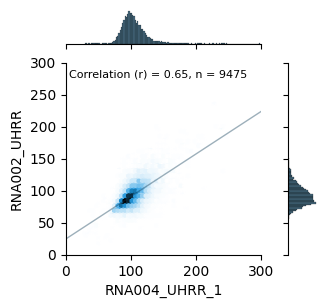

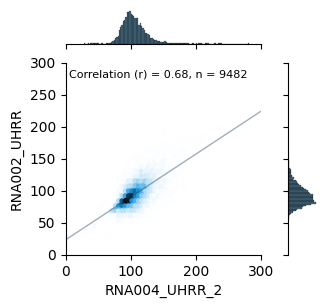

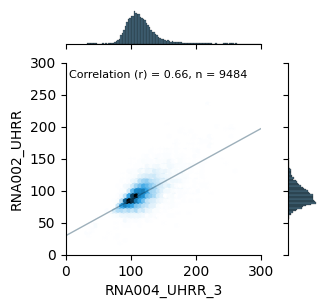

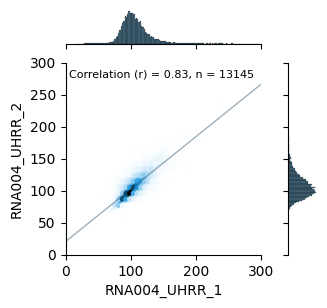

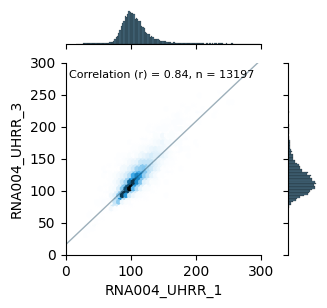

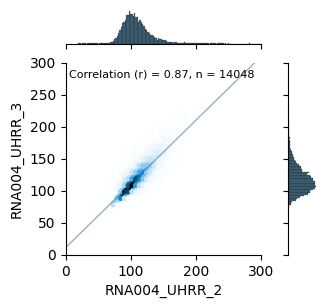

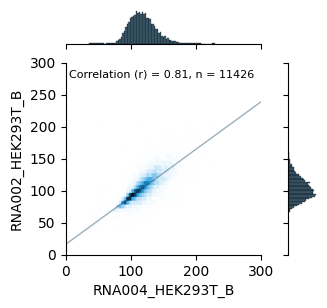

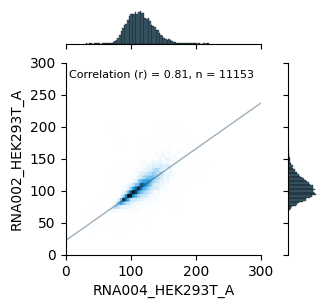

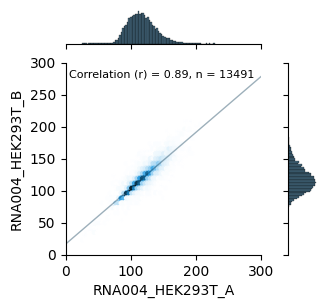

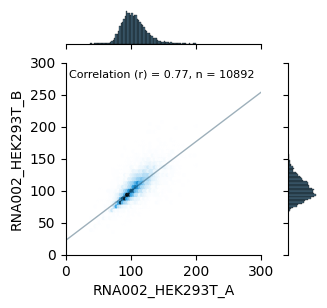

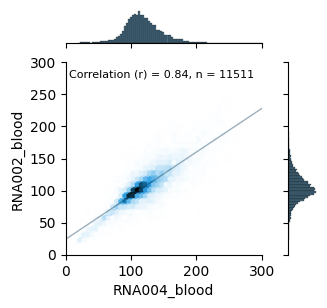

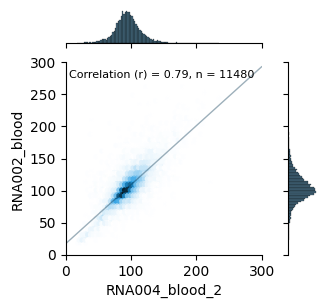

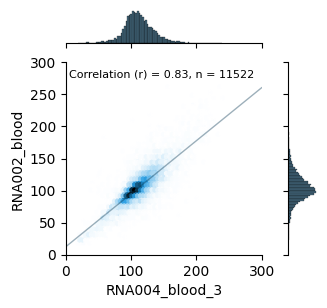

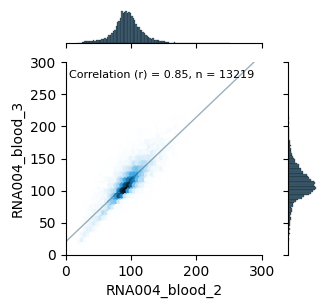

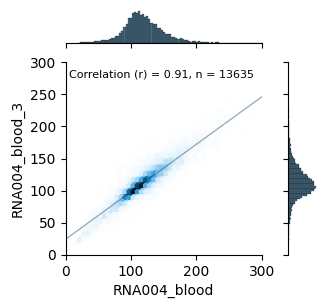

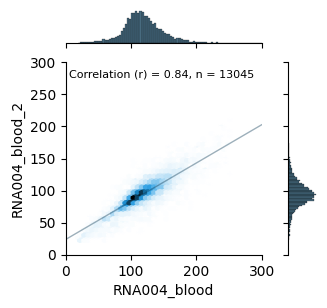

In [219]:
from sklearn.linear_model import LinearRegression
for i in comp_list:
    plots = []
    col_counts = ["count-" + k for k in i]
    col_means = ["mean_tail-" +  k for k in i]
    input_col = col_counts + col_means
    print(input_col)
    new_df = all_tails_protein[input_col].dropna()
    
    new_df_cov10 = new_df[(new_df[col_counts[0]] >= 10) & (new_df[col_counts[1]] >= 10)]
    print(len(new_df))
    print(len(new_df_cov10))
    
    g = sns.jointplot(x=col_means[0], y=col_means[1], data=new_df_cov10, kind='hex', color="#0B3954", height=4, ratio=4)
    corr = np.corrcoef(new_df_cov10[col_means[0]], new_df_cov10[col_means[1]])[0, 1]
    # Add correlation coefficient as text
    g.ax_joint.set_xlim(0, 300)  # Change x-axis limits
    g.ax_joint.set_ylim(0, 300) 
    
    X = new_df_cov10[col_means[0]].values.reshape(-1, 1)
    y = new_df_cov10[col_means[1]].values
    model = LinearRegression().fit(X, y)
    x_vals = np.array([0, 300])  # Based on your axis limits
    y_vals = model.predict(x_vals.reshape(-1, 1))
    g.ax_joint.plot(x_vals, y_vals, color='#0B3954', linestyle='-', linewidth=1, label = "Linear regression", alpha = 0.4)
    g.ax_joint.text(
        5,                          # x position (adjust if needed)
        290,                        # y position (just below upper y-limit)
        f'Correlation (r) = {corr:.2f}, n = {len(new_df_cov10):.0f}', 
        fontsize=8,
        color='black',
        ha='left',
        va='top'
    )
    
    #g.fig.suptitle(f'Correlation (r) = {corr:.2f}', fontsize=14)
    g.fig.tight_layout()
    g.set_axis_labels(i[0].replace("mean_tail-", ""), i[1].replace("mean_tail-", ""))
    #g.fig.subplots_adjust(top=1)
    

    g.fig.set_size_inches(3.2, 3)
    # Save figure
    g.fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_correlation_" + i[0].replace("mean_tail-", "") + "vs" + i[1].replace("mean_tail-", "") + "_protein.png", dpi=300)
    g.fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_correlation_" + i[0].replace("mean_tail-", "") + "vs" + i[1].replace("mean_tail-", "") + "_protein.pdf", dpi=300)


['count-RNA004_UHRR_1', 'count-RNA002_UHRR', 'mean_tail-RNA004_UHRR_1', 'mean_tail-RNA002_UHRR']
14279
9475
['count-RNA004_UHRR_2', 'count-RNA002_UHRR', 'mean_tail-RNA004_UHRR_2', 'mean_tail-RNA002_UHRR']
14352
9482
['count-RNA004_UHRR_3', 'count-RNA002_UHRR', 'mean_tail-RNA004_UHRR_3', 'mean_tail-RNA002_UHRR']
14372
9484
['count-RNA004_UHRR_1', 'count-RNA004_UHRR_2', 'mean_tail-RNA004_UHRR_1', 'mean_tail-RNA004_UHRR_2']
15366
13145
['count-RNA004_UHRR_1', 'count-RNA004_UHRR_3', 'mean_tail-RNA004_UHRR_1', 'mean_tail-RNA004_UHRR_3']
15462
13197
['count-RNA004_UHRR_2', 'count-RNA004_UHRR_3', 'mean_tail-RNA004_UHRR_2', 'mean_tail-RNA004_UHRR_3']
15671
14048
['count-RNA004_HEK293T_B', 'count-RNA002_HEK293T_B', 'mean_tail-RNA004_HEK293T_B', 'mean_tail-RNA002_HEK293T_B']
14432
11426
['count-RNA004_HEK293T_A', 'count-RNA002_HEK293T_A', 'mean_tail-RNA004_HEK293T_A', 'mean_tail-RNA002_HEK293T_A']
14343
11153
['count-RNA004_HEK293T_A', 'count-RNA004_HEK293T_B', 'mean_tail-RNA004_HEK293T_A', 'mea

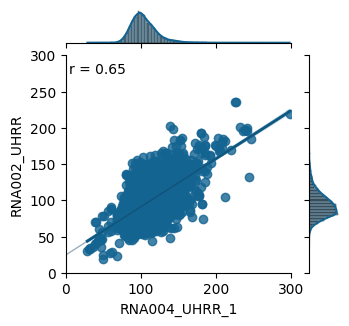

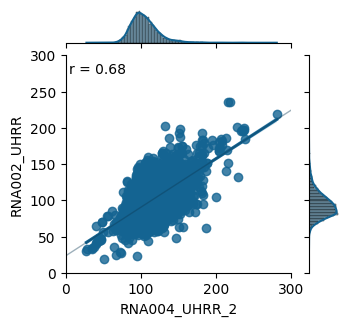

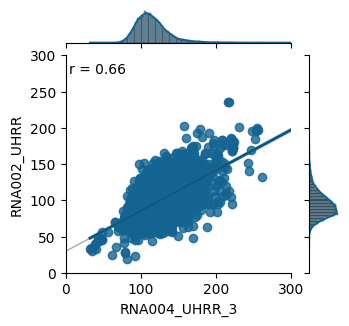

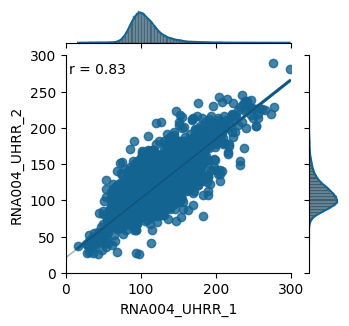

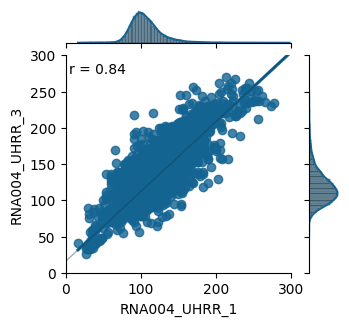

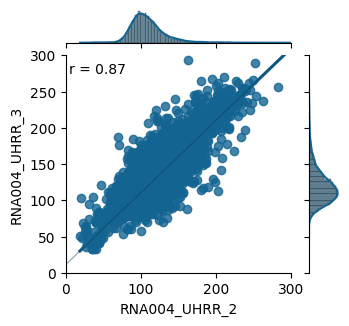

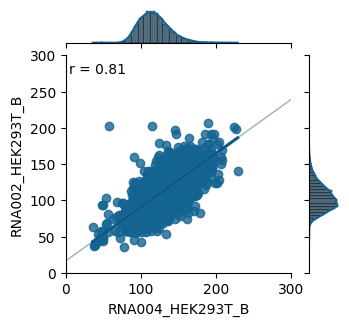

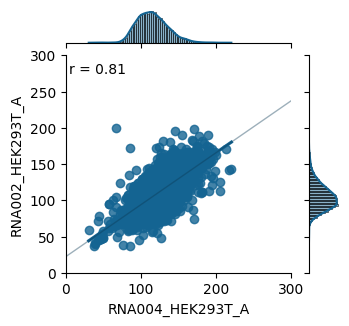

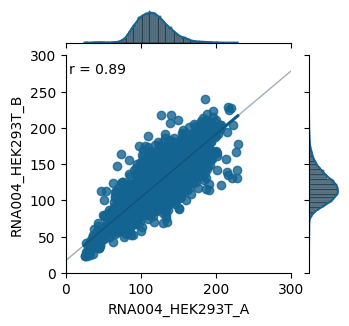

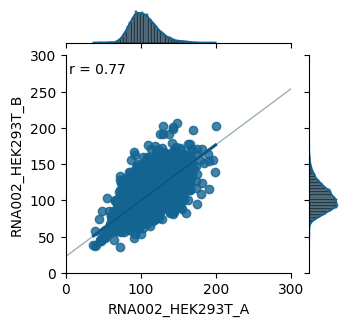

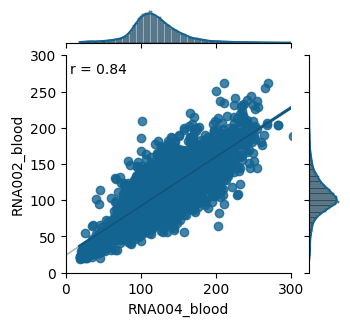

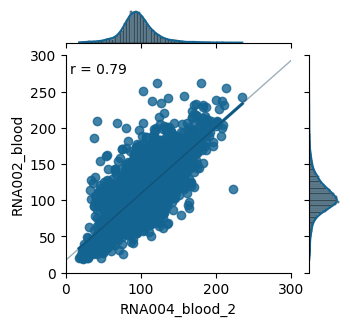

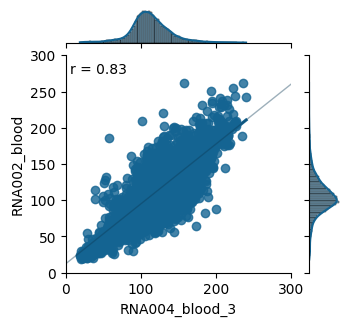

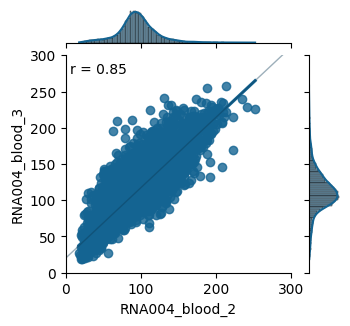

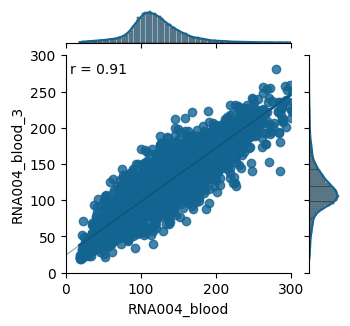

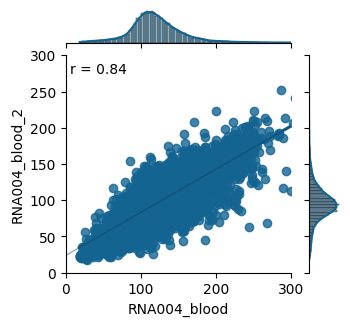

In [103]:
from sklearn.linear_model import LinearRegression
for i in comp_list:
    plots = []
    col_counts = ["count-" + k for k in i]
    col_means = ["mean_tail-" +  k for k in i]
    input_col = col_counts + col_means
    print(input_col)
    new_df = all_tails_protein[input_col].dropna()
    
    new_df_cov10 = new_df[(new_df[col_counts[0]] >= 10) & (new_df[col_counts[1]] >= 10)]
    print(len(new_df))
    print(len(new_df_cov10))
    
    g = sns.jointplot(x=col_means[0], y=col_means[1], data=new_df_cov10, kind='reg', color="#146492")
    corr = np.corrcoef(new_df_cov10[col_means[0]], new_df_cov10[col_means[1]])[0, 1]
    # Add correlation coefficient as text
    g.ax_joint.set_xlim(0, 300)  # Change x-axis limits
    g.ax_joint.set_ylim(0, 300) 
    
    X = new_df_cov10[col_means[0]].values.reshape(-1, 1)
    y = new_df_cov10[col_means[1]].values
    model = LinearRegression().fit(X, y)
    x_vals = np.array([0, 300])  # Based on your axis limits
    y_vals = model.predict(x_vals.reshape(-1, 1))
    g.ax_joint.plot(x_vals, y_vals, color='#0B3954', linestyle='-', linewidth=1, label = "Linear regression", alpha = 0.4)
    g.ax_joint.text(
        5,                          # x position (adjust if needed)
        290,                        # y position (just below upper y-limit)
        f'r = {corr:.2f}', 
        fontsize=10,
        color='black',
        ha='left',
        va='top'
    )
    
    #g.fig.suptitle(f'Correlation (r) = {corr:.2f}', fontsize=14)
    g.fig.tight_layout()
    g.set_axis_labels(i[0].replace("mean_tail-", ""), i[1].replace("mean_tail-", ""))
    #g.fig.subplots_adjust(top=1)
    

    g.fig.set_size_inches(3.2, 3)
    # Save figure
    g.fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_correlation_reg" + i[0].replace("mean_tail-", "") + "vs" + i[1].replace("mean_tail-", "") + "_protein.png", dpi=300)
    g.fig.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_genewise_correlation_reg" + i[0].replace("mean_tail-", "") + "vs" + i[1].replace("mean_tail-", "") + "_protein.pdf", dpi=300)


### SAVE TABLE

In [104]:
all_tails.to_csv("/home/awiercze/NEW_RNA004_PLOTS/TABLES/PAPER_polyA_tail_genewise_mean_length.tsv", sep = "\t", index = False)

## 4.3) TOOL COMPARISON: TAILFINDR VS DORADO

In [105]:
import pandas as pd

In [106]:
dorado_tails = pd.read_csv("/home/awiercze/NEW_RNA004_PLOTS/pod5_rna_rep3_sqkrna002.0.7.2.poly_a_tags.tsv", sep="\t", header=None, names = ["read_id", "sample", "polyA_length"])
tailfindr_tails = pd.read_csv("/home/awiercze/NEW_RNA004_PLOTS/rna_kr_data.tsv", sep="\t")

In [8]:
dorado_tails

,readID,sample,polyA_length
0,128e518a-6701-4b17-8741-e1ce32d50e90,pod5_rna_rep3_sqkrna002.0.7.2,84
1,d4782efc-9795-4243-a205-b78e15a8dca4,pod5_rna_rep3_sqkrna002.0.7.2,30
2,5c0ccbe3-245f-4927-bc82-0492fa99ef9e,pod5_rna_rep3_sqkrna002.0.7.2,12
3,6cbb1fa4-3155-4a7a-8eb3-0868d93659ab,pod5_rna_rep3_sqkrna002.0.7.2,36
4,2d763de9-37fe-4196-ae64-4f13dce799bf,pod5_rna_rep3_sqkrna002.0.7.2,40
...,...,...,...
464281,672db821-9c74-4568-810b-0bcf75a22745,pod5_rna_rep3_sqkrna002.0.7.2,56
464282,55cefeb4-d5c8-4659-9606-92c5585df028,pod5_rna_rep3_sqkrna002.0.7.2,45
464283,795940c2-f87c-48b9-8cd8-6ef9828675d3,pod5_rna_rep3_sqkrna002.0.7.2,43
464284,8e7de701-c3ac-4461-a016-ee21a8284883,pod5_rna_rep3_sqkrna002.0.7.2,45


In [107]:
tailfindr_tails = tailfindr_tails[["read_id", "barcode", "replicate", "tail_length_tf"]]
tailfindr_tails = tailfindr_tails[tailfindr_tails["replicate"] == 3]

In [108]:
dorado_tails_sub = pd.merge(tailfindr_tails[["read_id", "barcode"]], dorado_tails, on = "read_id", how = "inner")
tailfindr_tails_sub = tailfindr_tails[tailfindr_tails["read_id"].isin(dorado_tails_sub["read_id"])]

In [109]:
dorado_tails_sub.columns = ["read_id", "barcode", "sample", "polyA_length"]
tailfindr_tails_sub.columns = ["read_id", "barcode", "sample", "polyA_length"]


In [110]:
dorado_tails_sub["source"] = "Dorado"
tailfindr_tails_sub["source"] = "Tailfindr"

/tmp/ipykernel_1487447/457682051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tailfindr_tails_sub["source"] = "Tailfindr"


In [111]:
polyA_all = pd.concat([dorado_tails_sub, tailfindr_tails_sub], axis = 0)

In [112]:
colors_input_tissue = {
"HEK293T" :  "#0b3954",
"blood" :"#098c9a", 
"blood_IVT" :"#ee6c4d", 
"UHRR" : "#8b5cf6"}
metadata['colors_tissue'] = [colors_input_tissue[i] for i in metadata.ID]

In [124]:
polyA_all["polyA_length"].min()

5.0

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


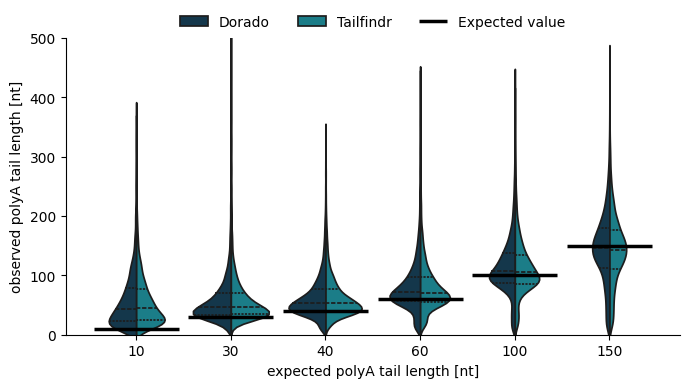

In [113]:

from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(7,4))
#sns.kdeplot(
#   data=polyA_all, x="polyA_length", hue="source",
#   fill=True, common_norm=False,
#   alpha=.2
#)
sns.violinplot(data=polyA_all, x="barcode", y="polyA_length", palette={"Dorado" : "#0b3954", "Tailfindr" : "#098c9a"}, hue="source", split=True, inner = "quartile")

expected_values = list(polyA_all["barcode"].sort_values().unique())
x_positions = range(len(expected_values))
for i, barcode in enumerate(expected_values):
    plt.hlines(
        y=barcode,
        xmin=i - 0.45,
        xmax=i + 0.45,
        colors='black',
        linewidth=2.5,
        label='Expected value' if i == 0 else None  # Avoid duplicate legend
    )
    
legend_elements = [
    Line2D([0], [0], color='black', lw=1.5, label='Expected length')
]

handles, labels = ax.get_legend_handles_labels()
handles.extend(legend_elements)
#labels.extend(['Expected value'])

# Set horizontal legend at top center
ax.legend(
    handles=handles,
    labels=labels,
    title="",
    loc='upper center',
    bbox_to_anchor=(0.5, 1.12),
    ncol=3,
    frameon=False
)

# Remove y-axis
#ax.set_yticks([])
ax.set_ylabel('observed polyA tail length [nt]')
ax.set_xlabel('expected polyA tail length [nt]')

#ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)  # Turn off all grid lines
ax.set_ylim(0, 500)

plt.tight_layout()
plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_length_comparison_tailfindr.png", dpi=300, transparent=True)
plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_length_comparison_tailfindr.pdf", dpi=300, transparent=True)

plt.show()

## 4.4) CONTROL: RCS POLY A TAIL LENGTH

In [114]:
import pandas as pd

In [115]:
RNA004_UHRR_RCS = pd.read_csv("/home/awiercze/NEW_RNA004_PLOTS/RNA004_UHRR_1_basecall.0.7.2.RCS.poly_a_tags.tsv", sep="\t", header=None, names = ["read_id", "sample", "polyA_length"])
RNA002_UHRR_RCS = pd.read_csv("/home/awiercze/NEW_RNA004_PLOTS/RNA002_UHRR_basecall.0.7.2.RCS.poly_a_tags.tsv", sep="\t", header=None, names = ["read_id", "sample", "polyA_length"])

In [116]:
RNA004_UHRR_RCS["source"] = "RNA004"
RNA002_UHRR_RCS["source"] = "RNA002"

In [117]:
polyA_all = pd.concat([RNA004_UHRR_RCS, RNA002_UHRR_RCS], axis = 0)

In [118]:
polyA_all["tissue"] = "RCS"

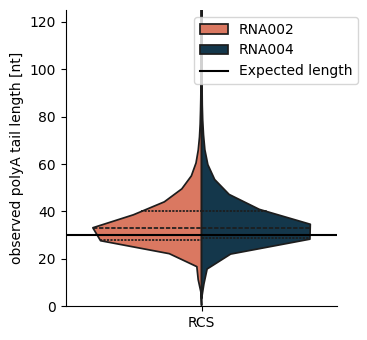

In [123]:

from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(3.8,3.5))
#sns.kdeplot(
#   data=polyA_all, x="polyA_length", hue="source",
#   fill=True, common_norm=False,
#   alpha=.2
#)
sns.violinplot(data=polyA_all, x="tissue", y="polyA_length", palette={"RNA004" : "#0b3954", "RNA002" : "#ee6c4d"}, hue_order = ["RNA002", "RNA004"], hue="source", split=True, inner = "quartile")
plt.axhline(y=30, color='black', linestyle='-', label='Expected length')

legend_elements = [
    Line2D([0], [0], color='black', lw=1.5, label='Expected length')
]


handles, labels = ax.get_legend_handles_labels()
handles.extend(legend_elements)
#labels.extend(['Expected value'])


# Set horizontal legend at top center
ax.legend(
    handles=handles,
    labels=labels,
    title="",
    #loc='top left',
    bbox_to_anchor=(1.1, 1),
    #ncol=3,
    #frameon=False
)

# Remove y-axis
#ax.set_yticks([])
ax.set_ylabel('observed polyA tail length [nt]')
ax.set_xlabel('')
#ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)  # Turn off all grid lines
ax.set_ylim(0, 125)

plt.tight_layout()
plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_length_comparison_RNA002_RNA004_RCS.png", dpi=300, transparent=True)
plt.savefig("/home/awiercze/NEW_RNA004_PLOTS/FIGURE2/PAPER_polyA_tail_length_comparison_RNA002_RNA004_RCS.pdf", dpi=300, transparent=True)

plt.show()

### SAVE TABLE

In [131]:
median_df = polyA_all.groupby(["source", "tissue"]).polyA_length.median().reset_index(name = "median_length")
mean_df = polyA_all.groupby(["source", "tissue"]).polyA_length.mean().reset_index(name = "mean_length")
pd.merge(median_df, mean_df, on = ["source", "tissue"]).to_csv("/home/awiercze/NEW_RNA004_PLOTS/TABLES/PAPER_TABLE_RCS_mean_median_polyA_length.tsv", sep = "\t", index = False)
